---
title: Assignment 04
author:
  - name: Wei Wang
    affiliations:
      - id: bu
        name: Boston University
        city: Boston
        state: MA
number-sections: true
date: '2025-10-04'
date-modified: today
date-format: long
format:
  html:
    theme: cerulean
    toc: true
    toc-depth: 2

execute:
  echo: false
  eval: false
  freeze: auto
---

# Load the Dataset

In [1]:
#| eval: true
#| echo: false
#| fig-align: center

from pyspark.sql import SparkSession
import pandas as pd
import plotly.express as px
import plotly.io as pio
import numpy as np

np.random.seed(42)

pio.renderers.default = "notebook+notebook_connected+vscode"

# Initialize Spark Session
spark = SparkSession.builder.appName("LightcastData").getOrCreate()

# Load Data
df = spark.read.option("header", "true").option("inferSchema", "true").option("multiLine","true").option("escape", "\"").csv("data/lightcast_job_postings.csv")

# Show Schema and Sample Data
# print("---This is Diagnostic check, No need to print it in the final doc---")

# df.printSchema() # comment this line when rendering the submission
df.show(5)
print((df.count(),len(df.columns)))

Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/10/06 04:38:29 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/10/06 04:38:50 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+-----------------+----------------------+----------+--------+---------+--------+--------------------+--------------------+--------------------+-----------+-------------------+--------------------+--------------------+---------------+----------------+--------+--------------------+-----------+-------------------+----------------+---------------------+-------------+-------------------+-------------+------------------+---------------+--------------------+--------------------+--------------------+-------------+------+-----------+----------------+-------------------+---------+-----------+--------------------+--------------------+-------------+------+--------------+-----+--------------------+-----+----------+---------------+--------------------+---------------+--------------------+------------+--------------------+------------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+--------------------+------+------

(72498, 131)


# Missing Value Treatment
Replace the missing values in Salary by Median of Salary based on the REMOTE_TYPE_NAME, if missing then replace with the overall median of Salary.

In [2]:
#| eval: true
#| echo: false
#| fig-align: center

from pyspark.sql import Window
from pyspark.sql.functions import col, when, isnan, count, expr, median
from pyspark.sql import functions as F

# Calculate overall median salary
overall_median_salary = df.approxQuantile("SALARY", [0.5], 0.01)[0]

# Calculate median salary by REMOTE_TYPE_NAME
remote_type_median = (
    df.groupBy("REMOTE_TYPE_NAME")
      .agg(expr("percentile_approx(SALARY, 0.5)").alias("remote_type_median_salary"))
)

# Join median values back to the original dataframe
df_salary_imputed = df.join(remote_type_median, on="REMOTE_TYPE_NAME", how="left")

# Replace missing SALARY values
df_salary_imputed = df_salary_imputed.withColumn(
    "SALARY",
    when(col("SALARY").isNull(),
         when(col("remote_type_median_salary").isNotNull(), col("remote_type_median_salary"))
         .otherwise(overall_median_salary)
    ).otherwise(col("SALARY"))
)

df_salary_imputed.show(5, truncate=False)
print((df_salary_imputed.count(),len(df_salary_imputed.columns)))

+----------------+----------------------------------------+-----------------+-----------------------+----------+--------+---------+--------+-------------------+---------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------+-------------------+-----------------------------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

(72498, 132)


# Feature Engineering

In [3]:
#| eval: true
#| echo: false
#| fig-align: center

from pyspark.sql.functions import col, pow, when
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.types import BooleanType, StringType, IntegerType

# Creating simplified REMOTE_TYPE column
df_eda = df_salary_imputed.withColumn(
    "REMOTE_TYPE",
    when(col("REMOTE_TYPE_NAME") == "Remote", "Remote")
    .when(col("REMOTE_TYPE_NAME") == "Hybrid Remote", "Hybrid")
    .when(col("REMOTE_TYPE_NAME") == "Not Remote", "Onsite")
    .otherwise("Undefined")
)

# Drop rows with missing values in relevant columns
df_features = df_eda.dropna(subset=[
    "SALARY", "MIN_YEARS_EXPERIENCE", "DURATION",
    "COMPANY_IS_STAFFING", "IS_INTERNSHIP",
     "STATE_NAME", "REMOTE_TYPE","remote_type_median_salary"
]).select(
    "SALARY", "MIN_YEARS_EXPERIENCE", "DURATION",
    "COMPANY_IS_STAFFING", "IS_INTERNSHIP",
     "STATE_NAME", "REMOTE_TYPE","remote_type_median_salary"
)

# Cast boolean columns to integer
df_features = df_features.withColumn("IS_INTERNSHIP", col("IS_INTERNSHIP").cast(IntegerType()))
df_features = df_features.withColumn("COMPANY_IS_STAFFING", col("COMPANY_IS_STAFFING").cast(IntegerType()))

df_features.show(5, truncate=False)


+--------+--------------------+--------+-------------------+-------------+--------------+-----------+-------------------------+
|SALARY  |MIN_YEARS_EXPERIENCE|DURATION|COMPANY_IS_STAFFING|IS_INTERNSHIP|STATE_NAME    |REMOTE_TYPE|remote_type_median_salary|
+--------+--------------------+--------+-------------------+-------------+--------------+-----------+-------------------------+
|118560.0|5                   |20      |1                  |0            |Indiana       |Remote     |112800                   |
|112800.0|1                   |30      |0                  |0            |Virginia      |Remote     |112800                   |
|156038.0|2                   |15      |0                  |0            |Oklahoma      |Remote     |112800                   |
|141600.0|7                   |54      |0                  |0            |South Carolina|Remote     |112800                   |
|130000.0|5                   |5       |0                  |0            |Massachusetts |Remote     |112

In [4]:
#| eval: true
#| echo: false
#| fig-align: center

# Categorical columns
categorical_cols = ["STATE_NAME", "REMOTE_TYPE"]

# Index and One-Hot Encode
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid='skip') for col in categorical_cols]
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_vec") for col in categorical_cols]

# Create squared experience feature
df_features = df_features.withColumn("MIN_YEARS_EXPERIENCE_SQ", pow(col("MIN_YEARS_EXPERIENCE"), 2))

# Assemble base features
base_features = [
    "MIN_YEARS_EXPERIENCE", "DURATION", "COMPANY_IS_STAFFING",
    "IS_INTERNSHIP", "STATE_NAME_vec", "REMOTE_TYPE_vec"
]

# Assemble polynomial features (add squared column)
poly_features = base_features + ["MIN_YEARS_EXPERIENCE_SQ"]

assembler_base = VectorAssembler(inputCols=base_features, outputCol="features")
assembler_poly = VectorAssembler(inputCols=poly_features, outputCol="features_poly")

# Build pipeline
pipeline = Pipeline(stages=indexers + encoders + [assembler_base, assembler_poly])

# Fit and transform
data = pipeline.fit(df_features).transform(df_features)

data.select("SALARY","features","features_poly").show(5, truncate=False)

+--------+-----------------------------------------+-------------------------------------------------+
|SALARY  |features                                 |features_poly                                    |
+--------+-----------------------------------------+-------------------------------------------------+
|118560.0|(57,[0,1,2,27,55],[5.0,20.0,1.0,1.0,1.0])|(58,[0,1,2,27,55,57],[5.0,20.0,1.0,1.0,1.0,25.0])|
|112800.0|(57,[0,1,7,55],[1.0,30.0,1.0,1.0])       |(58,[0,1,7,55,57],[1.0,30.0,1.0,1.0,1.0])        |
|156038.0|(57,[0,1,34,55],[2.0,15.0,1.0,1.0])      |(58,[0,1,34,55,57],[2.0,15.0,1.0,1.0,4.0])       |
|141600.0|(57,[0,1,30,55],[7.0,54.0,1.0,1.0])      |(58,[0,1,30,55,57],[7.0,54.0,1.0,1.0,49.0])      |
|130000.0|(57,[0,1,16,55],[5.0,5.0,1.0,1.0])       |(58,[0,1,16,55,57],[5.0,5.0,1.0,1.0,25.0])       |
+--------+-----------------------------------------+-------------------------------------------------+
only showing top 5 rows


# Train/Test Split
I split the data into 80% training and 20% testing, a common and balanced choice for regression tasks. This ensures the model has sufficient data to learn patterns effectively while keeping enough unseen data to evaluate performance reliably. With over 24,000 training samples, the model has sufficient data to learn complex patterns without overfitting.

In [5]:
#| eval: true
#| echo: false
#| fig-align: center

# Split Data
data_train, data_test = data.randomSplit([0.8, 0.2], seed=42)

print((data.count(), len(data.columns)))
print((data_train.count(), len(data_train.columns)))
print((data_test.count(), len(data_test.columns)))

(30018, 15)


(24046, 15)


(5972, 15)


# Linear Regression

In [6]:
#| eval: true
#| echo: false
#| fig-align: center

from pyspark.ml.regression import GeneralizedLinearRegression

feature_names = assembler_base.getInputCols()

# Fit the pipeline to extract metadata
fitted_pipeline = pipeline.fit(df_features)

# Extract category Labels from StringIndexer
state_indexer = fitted_pipeline.stages[0]  # StringIndexer for STATE_NAME
remote_indexer = fitted_pipeline.stages[1]  # StringIndexer for REMOTE_TYPE

state_labels = state_indexer.labels
remote_labels = remote_indexer.labels

# Create one-hot encoded feature names
state_ohe_features = [f"STATE_NAME={label}" for label in state_labels[1:]]
remote_ohe_features = [f"REMOTE_TYPE={label}" for label in remote_labels[1:]]

# Construct full feature name list
base_feature_names = ["MIN_YEARS_EXPERIENCE", "DURATION", "COMPANY_IS_STAFFING", "IS_INTERNSHIP"]
full_feature_names = base_feature_names + state_ohe_features + remote_ohe_features

# Fit Generalized Linear Regression
glr = GeneralizedLinearRegression(
    featuresCol="features",
    labelCol="SALARY",
    family="gaussian", # normal distribution
    link="identity",  # standard linear regression
    maxIter=10,
    regParam=0.3
)

glr_model = glr.fit(data_train)
summary = glr_model.summary

# Print coefficients and intercept
print(f"Intercept: {glr_model.intercept:.4f}")
print("Coefficients:")
for name, coef in zip(full_feature_names, glr_model.coefficients):
    print(f"{name}: {coef:.4f}")

Intercept: 89374.0457
Coefficients:
MIN_YEARS_EXPERIENCE: 3251.8029
DURATION: 52.9662
COMPANY_IS_STAFFING: -1046.2547
IS_INTERNSHIP: 2469.1519
STATE_NAME=California: -1740.9803
STATE_NAME=Florida: 3263.9469
STATE_NAME=Virginia: -642.5545
STATE_NAME=North Carolina: -953.2710
STATE_NAME=New York: -1430.8442
STATE_NAME=Georgia: 675.9094
STATE_NAME=Ohio: -1186.8059
STATE_NAME=Illinois: -1115.1772
STATE_NAME=New Jersey: -808.2849
STATE_NAME=Pennsylvania: 296.6392
STATE_NAME=Michigan: -230.6087
STATE_NAME=Massachusetts: 3195.4175
STATE_NAME=Arizona: 708.5789
STATE_NAME=Washington: -2977.0674
STATE_NAME=Colorado: 3416.8898
STATE_NAME=Minnesota: -3602.9543
STATE_NAME=Maryland: 1566.9838
STATE_NAME=Tennessee: 129.7051
STATE_NAME=Oregon: -632.0119
STATE_NAME=Washington, D.C. (District of Columbia): -6866.5979
STATE_NAME=Missouri: -921.9981
STATE_NAME=Wisconsin: -1767.3414
STATE_NAME=Indiana: -41.3127
STATE_NAME=Connecticut: -2569.3129
STATE_NAME=Kansas: 2240.2984
STATE_NAME=South Carolina: 410.3

In [7]:
#| eval: true
#| echo: false
#| fig-align: center

from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate Model on Test Set
predictions = glr_model.transform(data_test)

evaluator = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction")

r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})

print("\n--- Model Performance on Test Set ---")
print(f"R²: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


--- Model Performance on Test Set ---
R²: 0.1222
RMSE: 26986.5798
MAE: 18352.0366


In [8]:
#| eval: true
#| echo: false
#| fig-align: center

# Summary stats
print("\n--- Regression Summary ---")
print("Coefficient Standard Errors:", [f"{val:.4f}" for val in summary.coefficientStandardErrors])
print("T-Values:", [f"{val:.4f}" for val in summary.tValues])
print("P-Values:", [f"{val:.4f}" for val in summary.pValues])



--- Regression Summary ---


Coefficient Standard Errors: ['53.7081', '12.3785', '516.1945', '2576.5194', '4055.6926', '4062.0215', '4092.7342', '4096.7060', '4117.8085', '4122.1924', '4122.4969', '4134.2609', '4134.1875', '4134.0380', '4147.1551', '4153.8512', '4157.3795', '4177.5490', '4195.0572', '4193.0230', '4202.9076', '4224.8547', '4227.0666', '4242.6322', '4249.8259', '4248.4598', '4300.7536', '4305.5019', '4343.2295', '4364.0299', '4384.9400', '4388.5709', '4397.8066', '4411.2294', '4392.4533', '4419.2320', '4438.7174', '4460.4431', '4461.1460', '4500.4111', '4567.9541', '4583.7416', '4594.1930', '4687.4315', '4761.1250', '4900.3385', '4953.0526', '4944.5064', '5013.4834', '5056.6065', '5104.4646', '5157.7044', '5690.2871', '5631.5408', '1486.7032', '1525.5189', '1805.9738', '4299.3863']
T-Values: ['60.5459', '4.2789', '-2.0269', '0.9583', '-0.4293', '0.8035', '-0.1570', '-0.2327', '-0.3475', '0.1640', '-0.2879', '-0.2697', '-0.1955', '0.0718', '-0.0556', '0.7693', '0.1704', '-0.7126', '0.8145', '-0.8593'

In [9]:
#| eval: true
#| echo: false
#| fig-align: center

# print(f"\nDispersion: {summary.dispersion:.4f}")
print(f"Null Deviance: {summary.nullDeviance:.4f}")
print(f"Residual DF Null: {summary.residualDegreeOfFreedomNull}")
print(f"Deviance: {summary.deviance:.4f}")
print(f"Residual DF: {summary.residualDegreeOfFreedom}")
print(f"AIC: {summary.aic:.4f}")


Null Deviance: 21369269316408.8320
Residual DF Null: 24045
Deviance: 18294288959931.5312
Residual DF: 23988


AIC: 560095.5533


In [12]:
#| eval: true
#| echo: false
#| fig-align: center

import pandas as pd
from tabulate import tabulate
from IPython.display import HTML

# Pull feature names directly from Java backend
feature_names = summary._call_java("featureNames")

# Construct full table including intercept
features = ["Intercept"] + list(feature_names)
coefs    = [glr_model.intercept] + list(glr_model.coefficients)
se       = list(summary.coefficientStandardErrors)
tvals    = list(summary.tValues)
pvals    = list(summary.pValues)

# Compute confidence intervals (95%)
lower_ci = [None if coef is None or s is None else coef - 1.96 * s for coef, s in zip(coefs, se)]
upper_ci = [None if coef is None or s is None else coef + 1.96 * s for coef, s in zip(coefs, se)]

# print("--- This is a diagnostic check, no need to print in the final doc ---")
# print("Length of features:", len(features))
# print("Length of coefs:", len(coefs))
# print("Length of se:", len(se))
# print("Length of tvals:", len(tvals))
# print("Length of pvals:", len(pvals))

# Build DataFrame
coef_table = pd.DataFrame({
    "Feature": features,
    "Estimate": [f"{v:.4f}" if v is not None else None for v in coefs],
    "Std Error": [f"{v:.4f}" if v is not None else None for v in se],
    "t-stat": [f"{v:.4f}" if v is not None else None for v in tvals],
    "P-Value": [f"{v:.4f}" if v is not None else None for v in pvals],
    "95% CI Lower": [f"{v:.4f}" if v is not None else None for v in lower_ci],
    "95% CI Upper": [f"{v:.4f}" if v is not None else None for v in upper_ci]
})

# Save for report
coef_table.to_csv("output/glr_summary.csv", index=False)

# Optional pretty print
HTML(coef_table.to_html())

,Feature,Estimate,Std Error,t-stat,P-Value,95% CI Lower,95% CI Upper
0,Intercept,89374.0457,53.7081,60.5459,0.0000,89268.7779,89479.3135
1,MIN_YEARS_EXPERIENCE,3251.8029,12.3785,4.2789,0.0000,3227.5411,3276.0647
2,DURATION,52.9662,516.1945,-2.0269,0.0427,-958.7750,1064.7074
3,COMPANY_IS_STAFFING,-1046.2547,2576.5194,0.9583,0.3379,-6096.2326,4003.7232
4,IS_INTERNSHIP,2469.1519,4055.6926,-0.4293,0.6677,-5480.0056,10418.3093
5,STATE_NAME_vec_Texas,-1740.9803,4062.0215,0.8035,0.4217,-9702.5425,6220.5819
6,STATE_NAME_vec_California,3263.9469,4092.7342,-0.1570,0.8752,-4757.8121,11285.7060
7,STATE_NAME_vec_Florida,-642.5545,4096.7060,-0.2327,0.8160,-8672.0983,7386.9893
8,STATE_NAME_vec_Virginia,-953.2710,4117.8085,-0.3475,0.7282,-9024.1757,7117.6337
9,STATE_NAME_vec_North Carolina,-1430.8442,4122.1924,0.1640,0.8698,-9510.3414,6648.6529


## Generalized Linear Regression Summary

The Generalized Linear Regression model provides key insights into how each feature affects the predicted salary and whether that effect is statistically significant.

### Coefficients:
- The coefficients represent the change in predicted salary associated with a one-unit increase in each feature, holding others constant.
- For example, the coefficient for `MIN_YEARS_EXPERIENCE` is 3251.80, meaning each additional year of minimum experience is associated with an estimated $3,251.80 increase in salary.
- `DURATION` has a small positive effect (~53) on salary, but is far less impactful than experience.

### Statistical Significance
- The t-statistic measures how many standard errors the coefficient is away from zero.
- The p-value tests the null hypothesis that a coefficient equals zero (no effect). A p-value < 0.05 typically indicates statistical significance.
- Significant predictors in this model include:
	- `MIN_YEARS_EXPERIENCE` (p < 0.001): Strong, positive, and statistically significant effect.
	- Several remote work types also show significant positive coefficients (all p < 0.001), suggesting remote or hybrid roles are associated with higher salaries than the baseline category.
	- `STATE_NAME_vec_Oklahoma` and `STATE_NAME_vec_Alaska` have significant negative coefficients, implying lower salaries in these states, with p-values < 0.05.
	- Most other state-related dummy variables have high p-values, indicating their effects are not statistically significant, possibly due to limited data or multicollinearity.

### Confidence Intervals (95%)
- A 95% confidence interval (CI) indicates the range within which the true value of a coefficient is expected to fall.
- When the CI does not include zero, the estimate is considered statistically significant.
For example, the CI for `MIN_YEARS_EXPERIENCE` is [3,227.54, 3,276.06], which does not include zero and therefore reflects a significant positive effect on salary. In contrast, the CI for `DURATION` is [–958.78, 1,064.71], which spans zero, indicating that this effect is not statistically significant.

### Intercept
The intercept of $89,374.05 represents the baseline salary when all numerical predictors are zero and categorical variables are in their reference category.

### Model Summary Metrics
- R² = 0.1222
The model explains about 12.2% of the variance in salary, suggesting limited explanatory power.
- RMSE ≈ $27,987
On average, predictions deviate by about $28K, indicating considerable prediction error.
- MAE ≈ $18,352
The average absolute error is roughly $18K, showing moderate accuracy.

The model captures some key salary drivers such as years of experience and remote work status, but leaves a large portion of variation unexplained, as indicated by the relatively low R² and notable prediction errors. This suggests that important predictors like industry, job role, or specific skill requirements may be missing from the feature set. To improve accuracy, future models should explore nonlinear approaches such as polynomial regression or ensemble methods like random forest.

# Polynomial Regression

In [13]:
#| eval: true
#| echo: false
#| fig-align: center

# Split Data
data_train, data_test = data.randomSplit([0.8, 0.2], seed=42)

print((data.count(), len(data.columns)))
print((data_train.count(), len(data_train.columns)))
print((data_test.count(), len(data_test.columns)))

(30018, 15)


(24046, 15)


(5972, 15)


In [14]:
#| eval: true
#| echo: false
#| fig-align: center

# Fit the pipeline to extract metadata
fitted_pipeline = pipeline.fit(df_features)

# Extract category Labels from StringIndexer
state_indexer = fitted_pipeline.stages[0]  # StringIndexer for STATE_NAME
remote_indexer = fitted_pipeline.stages[1]  # StringIndexer for REMOTE_TYPE

state_labels = state_indexer.labels
remote_labels = remote_indexer.labels

# Create one-hot encoded feature names
state_ohe_features = [f"STATE_NAME={label}" for label in state_labels[1:]]
remote_ohe_features = [f"REMOTE_TYPE={label}" for label in remote_labels[1:]]

# Construct full feature name list
base_feature_names = ["MIN_YEARS_EXPERIENCE", "DURATION", "COMPANY_IS_STAFFING", "IS_INTERNSHIP"]
poly_feature_names = base_feature_names + state_ohe_features + remote_ohe_features+ ["MIN_YEARS_EXPERIENCE_SQ"]

# Train Polynomial Regression
glr_poly = GeneralizedLinearRegression(
    featuresCol="features_poly",
    labelCol="SALARY",
    family="gaussian",
    link="identity",
    maxIter=10,
    regParam=0.3
)

glr_poly_model = glr_poly.fit(data_train)
summary_poly = glr_poly_model.summary

# Print coefficients with feature names
print(f"Intercept: {glr_poly_model.intercept:.4f}")
print("Coefficients:")
for name, coef in zip(poly_feature_names, glr_poly_model.coefficients):
    print(f"{name}: {coef:.4f}")


Intercept: 82915.3745
Coefficients:
MIN_YEARS_EXPERIENCE: 6163.8997
DURATION: 55.0244
COMPANY_IS_STAFFING: -1244.4820
IS_INTERNSHIP: 4004.3058
STATE_NAME=California: -2121.2147
STATE_NAME=Florida: 3079.1001
STATE_NAME=Virginia: -936.3855
STATE_NAME=North Carolina: -1095.8663
STATE_NAME=New York: -1690.6799
STATE_NAME=Georgia: 624.5248
STATE_NAME=Ohio: -1185.0116
STATE_NAME=Illinois: -1175.5197
STATE_NAME=New Jersey: -942.6561
STATE_NAME=Pennsylvania: 237.3190
STATE_NAME=Michigan: -385.7863
STATE_NAME=Massachusetts: 3036.2036
STATE_NAME=Arizona: 834.2433
STATE_NAME=Washington: -3192.0601
STATE_NAME=Colorado: 3375.2714
STATE_NAME=Minnesota: -4006.4685
STATE_NAME=Maryland: 1381.6812
STATE_NAME=Tennessee: -52.4199
STATE_NAME=Oregon: -633.5596
STATE_NAME=Washington, D.C. (District of Columbia): -7457.8744
STATE_NAME=Missouri: -988.8061
STATE_NAME=Wisconsin: -2139.3906
STATE_NAME=Indiana: -155.8154
STATE_NAME=Connecticut: -2736.4208
STATE_NAME=Kansas: 1941.1805
STATE_NAME=South Carolina: 265

In [15]:
#| eval: true
#| echo: false
#| fig-align: center

# Evaluate model performance
predictions_poly = glr_poly_model.transform(data_test)

evaluator = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction")
r2_poly = evaluator.evaluate(predictions_poly, {evaluator.metricName: "r2"})
rmse_poly = evaluator.evaluate(predictions_poly, {evaluator.metricName: "rmse"})
mae_poly = evaluator.evaluate(predictions_poly, {evaluator.metricName: "mae"})

print("\n--- Polynomial Model Performance on Test Set ---")
print(f"R²: {r2_poly:.4f}")
print(f"RMSE: {rmse_poly:.4f}")
print(f"MAE: {mae_poly:.4f}")


--- Polynomial Model Performance on Test Set ---
R²: 0.1340
RMSE: 26803.5848
MAE: 18584.6367


In [17]:
#| eval: true
#| echo: false
#| fig-align: center

# Pull feature names directly from Java backend
feature_names = summary._call_java("featureNames")

# Construct full table including intercept
features_poly_all = ["Intercept"] + list(poly_feature_names)
coefs_poly    = [glr_poly_model.intercept] + list(glr_poly_model.coefficients)
se_poly       = list(summary_poly.coefficientStandardErrors)
tvals_poly    = list(summary_poly.tValues)
pvals_poly    = list(summary_poly.pValues)

# Compute 95% confidence intervals
lower_ci_poly = [None if se is None or coef is None else coef - 1.96 * se for coef, se in zip(coefs_poly, se_poly)]
upper_ci_poly = [None if se is None or coef is None else coef + 1.96 * se for coef, se in zip(coefs_poly, se_poly)]

coef_table_poly = pd.DataFrame({
    "Feature": features_poly_all,
    "Estimate": [f"{v:.4f}" if v is not None else None for v in coefs_poly],
    "Std Error": [f"{v:.4f}" if v is not None else None for v in se_poly],
    "t-stat": [f"{v:.4f}" if v is not None else None for v in tvals_poly],
    "P-Value": [f"{v:.4f}" if v is not None else None for v in pvals_poly],
    "95% CI Lower": [f"{v:.4f}" if v is not None else None for v in lower_ci_poly],
    "95% CI Upper": [f"{v:.4f}" if v is not None else None for v in upper_ci_poly]
})

# Save for report
coef_table_poly.to_csv("output/polynomial_glr_summary.csv", index=False)

# Optional pretty print
HTML(coef_table_poly.to_html(index=False))

Feature,Estimate,Std Error,t-stat,P-Value,95% CI Lower,95% CI Upper
Intercept,82915.3745,187.6198,32.8531,0.0000,82547.6397,83283.1093
MIN_YEARS_EXPERIENCE,6163.8997,12.3123,4.4691,0.0000,6139.7677,6188.0317
DURATION,55.0244,513.5519,-2.4233,0.0154,-951.5372,1061.5861
COMPANY_IS_STAFFING,-1244.4820,2564.3539,1.5615,0.1184,-6270.6155,3781.6516
IS_INTERNSHIP,4004.3058,4033.8513,-0.5259,0.5990,-3902.0427,11910.6543
STATE_NAME=California,-2121.2147,4040.0938,0.7621,0.4460,-10039.7985,5797.3692
STATE_NAME=Florida,3079.1001,4070.6649,-0.2300,0.8181,-4899.4031,11057.6032
STATE_NAME=Virginia,-936.3855,4074.5843,-0.2690,0.7880,-8922.5708,7049.7998
STATE_NAME=North Carolina,-1095.8663,4095.5947,-0.4128,0.6798,-9123.2320,6931.4994
STATE_NAME=New York,-1690.6799,4099.9247,0.1523,0.8789,-9726.5324,6345.1726


## Polynomial Regression Summary
The polynomial regression model reveals a non-linear relationship between experience and salary.
- `MIN_YEARS_EXPERIENCE` is highly significant (p < 0.001), with a positive effect (~$6,164 per year), while the squared term is negative and significant, indicating diminishing returns as experience increases.
- Remote work types (Remote, Hybrid, Onsite) are also strong predictors, all with p < 0.001. Remote roles offer the highest premium (~$9,234).
- Most `STATE_NAME` variables and other binary features (like `IS_INTERNSHIP`) are not statistically significant, as their confidence intervals include zero.

Overall, the model confirms that experience and work location type are key drivers of salary, while the impact of individual states is less conclusive.

# Random Forest Regressor

In [18]:
#| eval: true
#| echo: false
#| fig-align: center

# Split Data
data_train, data_test = data.randomSplit([0.8, 0.2], seed=42)

print((data.count(), len(data.columns)))
print((data_train.count(), len(data_train.columns)))
print((data_test.count(), len(data_test.columns)))

(30018, 15)


(24046, 15)


(5972, 15)


In [20]:
#| eval: true
#| echo: false
#| fig-align: center

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# Train the Random Forest Regressor
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="SALARY",
    numTrees=200,
    maxDepth=6,
    seed=42
)

rf_model = rf.fit(data_train)

# Make predictions on test data
predictions_rf = rf_model.transform(data_test)

# Evaluate model performance
evaluator = RegressionEvaluator(labelCol="SALARY", predictionCol="prediction")
r2_rf = evaluator.evaluate(predictions_rf, {evaluator.metricName: "r2"})
rmse_rf = evaluator.evaluate(predictions_rf, {evaluator.metricName: "rmse"})
mae_rf = evaluator.evaluate(predictions_rf, {evaluator.metricName: "mae"})

print(f"Random Forest R²: {r2_rf:.4f}")
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"Random Forest MAE: {mae_rf:.2f}")

25/10/06 04:52:20 WARN DAGScheduler: Broadcasting large task binary with size 1241.6 KiB
25/10/06 04:52:24 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


Random Forest R²: 0.1552
Random Forest RMSE: 26474.54
Random Forest MAE: 18025.41


## Feature Importance Plot

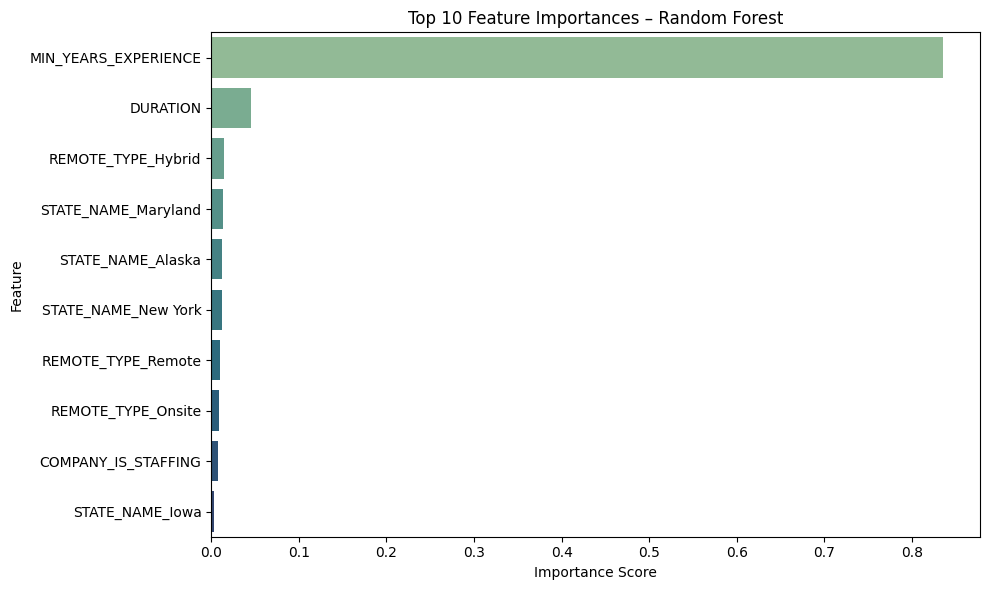

In [21]:
#| eval: true
#| echo: false
#| fig-align: center

# Expand feature names with one-hot encoded categories
def get_expanded_feature_names(data, base_feature_names):
    """
    Expands feature names to include individual one-hot encoded categories
    """
    expanded_names = []
    
    for feature in base_feature_names:
        if feature.endswith("_vec"):
            # This is a one-hot encoded feature
            original_col = feature.replace("_vec", "")
            # Get the size of the vector (number of categories)
            sample_row = data.select(feature).first()
            vec_size = len(sample_row[0])
            
            # Get distinct values from the original column
            categories = data.select(original_col).distinct().rdd.flatMap(lambda x: x).collect()
            categories = sorted(categories)[:vec_size]
            
            # Add each category as a separate feature name
            for category in categories:
                expanded_names.append(f"{original_col}_{category}")
        else:
            # Regular numeric feature
            expanded_names.append(feature)
    
    return expanded_names

# Get feature names from assembler
base_feature_names = assembler_base.getInputCols()

# Expand feature names to match the actual feature vector
expanded_feature_names = get_expanded_feature_names(data, base_feature_names)

# Extract feature importances
importances = rf_model.featureImportances.toArray()

# Create DataFrame for plotting
importance_df = pd.DataFrame({
    "Feature": expanded_feature_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

# Plot top 10
plt.figure(figsize=(10, 6))
sns.barplot(
    data=importance_df.head(10),
    x="Importance",
    y="Feature",
    hue="Feature",
    palette="crest",
    legend=False
)
plt.title("Top 10 Feature Importances – Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.savefig("output/rf_feature_importance.png")
plt.show()

# Compare 3 Models – GLR, Polynomial, RF

In [27]:
#| eval: true
#| echo: false
#| fig-align: center

from pyspark.sql.functions import monotonically_increasing_id

# Drop existing feature columns if they exist
for col_name in ["features", "features_poly"]:
    if col_name in data_test.columns:
        data_test = data_test.drop(col_name)

# Apply assemblers to test data to create features columns
data_test_with_features = assembler_base.transform(data_test)
data_test_with_features = assembler_poly.transform(data_test_with_features)

# Generate predictions for each model
pred_glr = glr_model.transform(data_test_with_features).select("SALARY", "prediction").withColumnRenamed("prediction", "pred_glr")
pred_poly = glr_poly_model.transform(data_test_with_features).select("SALARY", "prediction").withColumnRenamed("prediction", "pred_poly")
pred_rf = rf_model.transform(data_test_with_features).select("SALARY", "prediction").withColumnRenamed("prediction", "pred_rf")

# Add row index for joining (since SALARY values might not be unique)
pred_glr = pred_glr.withColumn("row_id", monotonically_increasing_id())
pred_poly = pred_poly.withColumn("row_id", monotonically_increasing_id())
pred_rf = pred_rf.withColumn("row_id", monotonically_increasing_id())

# Combine all predictions using row_id
predictions_combined = pred_glr.join(
    pred_poly.select("row_id", "pred_poly"), on="row_id"
).join(
    pred_rf.select("row_id", "pred_rf"), on="row_id"
).drop("row_id")

# Rename SALARY to actual_salary for clarity
predictions_combined = predictions_combined.withColumnRenamed("SALARY", "actual_salary")

# Show sample
print("Sample Predictions:")
predictions_combined.show(10, truncate=False)

Sample Predictions:


+-------------+------------------+------------------+------------------+
|actual_salary|pred_glr          |pred_poly         |pred_rf           |
+-------------+------------------+------------------+------------------+
|22880.0      |103092.7091291591 |98563.46397441733 |103581.45903375004|
|27040.0      |114722.79894853667|116624.82844644046|118107.7133153791 |
|29250.0      |106387.15402937846|102015.12429133395|104126.72780515664|
|31200.0      |105906.91741104332|103671.03402244706|105335.24199659078|
|31200.0      |109120.48534623536|110792.94864260886|101173.12701452638|
|31200.0      |113221.88080766413|115278.86075398751|117722.01193313305|
|32885.0      |114715.13772785894|116725.21649875793|117976.5886305633 |
|33176.0      |109279.38401632855|110958.02198891554|101468.9052086865 |
|33800.0      |116456.81948164813|118469.9510249031 |119124.27717751377|
|33925.0      |106228.25535928528|101850.05094502727|104637.4874738687 |
+-------------+------------------+-----------------

In [29]:
#| eval: true
#| echo: false
#| fig-align: center

import math

# Evaluators
evaluator_r2 = RegressionEvaluator(labelCol="actual_salary", predictionCol="prediction", metricName="r2")
evaluator_rmse = RegressionEvaluator(labelCol="actual_salary", predictionCol="prediction", metricName="rmse")
evaluator_mae = RegressionEvaluator(labelCol="actual_salary", predictionCol="prediction", metricName="mae")

# Count of test samples
n = predictions_combined.count()

# GLR
glr_pred_df = predictions_combined.select("actual_salary", predictions_combined["pred_glr"].alias("prediction"))
rmse_glr = evaluator_rmse.evaluate(glr_pred_df)
mae_glr = evaluator_mae.evaluate(glr_pred_df)
r2_glr = evaluator_r2.evaluate(glr_pred_df)
aic_glr = glr_model.summary.aic
p_glr = len(glr_model.coefficients) + 1  # +1 for intercept
bic_glr = n * math.log(rmse_glr ** 2) + p_glr * math.log(n)

# Polynomial
poly_pred_df = predictions_combined.select("actual_salary", predictions_combined["pred_poly"].alias("prediction"))
rmse_poly = evaluator_rmse.evaluate(poly_pred_df)
mae_poly = evaluator_mae.evaluate(poly_pred_df)
r2_poly = evaluator_r2.evaluate(poly_pred_df)
aic_poly = glr_poly_model.summary.aic
p_poly = len(glr_poly_model.coefficients) + 1
bic_poly = n * math.log(rmse_poly ** 2) + p_poly * math.log(n)

# Random Forest
rf_pred_df = predictions_combined.select("actual_salary", predictions_combined["pred_rf"].alias("prediction"))
rmse_rf = evaluator_rmse.evaluate(rf_pred_df)
mae_rf = evaluator_mae.evaluate(rf_pred_df)
r2_rf = evaluator_r2.evaluate(rf_pred_df)
aic_rf = None  # AIC not available for tree models
p_rf = len(rf_model.featureImportances.toArray().tolist())
bic_rf = n * math.log(rmse_rf ** 2) + p_rf * math.log(n)

# Print Results
print("\nModel Evaluation Summary:")
print(f"{'Model':<20} {'RMSE':>10} {'MAE':>10} {'R²':>10} {'AIC':>12} {'BIC':>12}")
print("-" * 74)
print(f"{'GLR':<20} {rmse_glr:10.2f} {mae_glr:10.2f} {r2_glr:10.4f} {aic_glr:12.2f} {bic_glr:12.2f}")
print(f"{'Polynomial GLR':<20} {rmse_poly:10.2f} {mae_poly:10.2f} {r2_poly:10.4f} {aic_poly:12.2f} {bic_poly:12.2f}")
print(f"{'Random Forest':<20} {rmse_rf:10.2f} {mae_rf:10.2f} {r2_rf:10.4f} {'N/A':>12} {bic_rf:12.2f}")


Model Evaluation Summary:
Model                      RMSE        MAE         R²          AIC          BIC
--------------------------------------------------------------------------
GLR                    26986.58   18352.04     0.1222    560095.55    122370.07
Polynomial GLR         26803.58   18584.64     0.1340    559836.04    122297.49
Random Forest          26474.54   18025.41     0.1552          N/A    122132.57


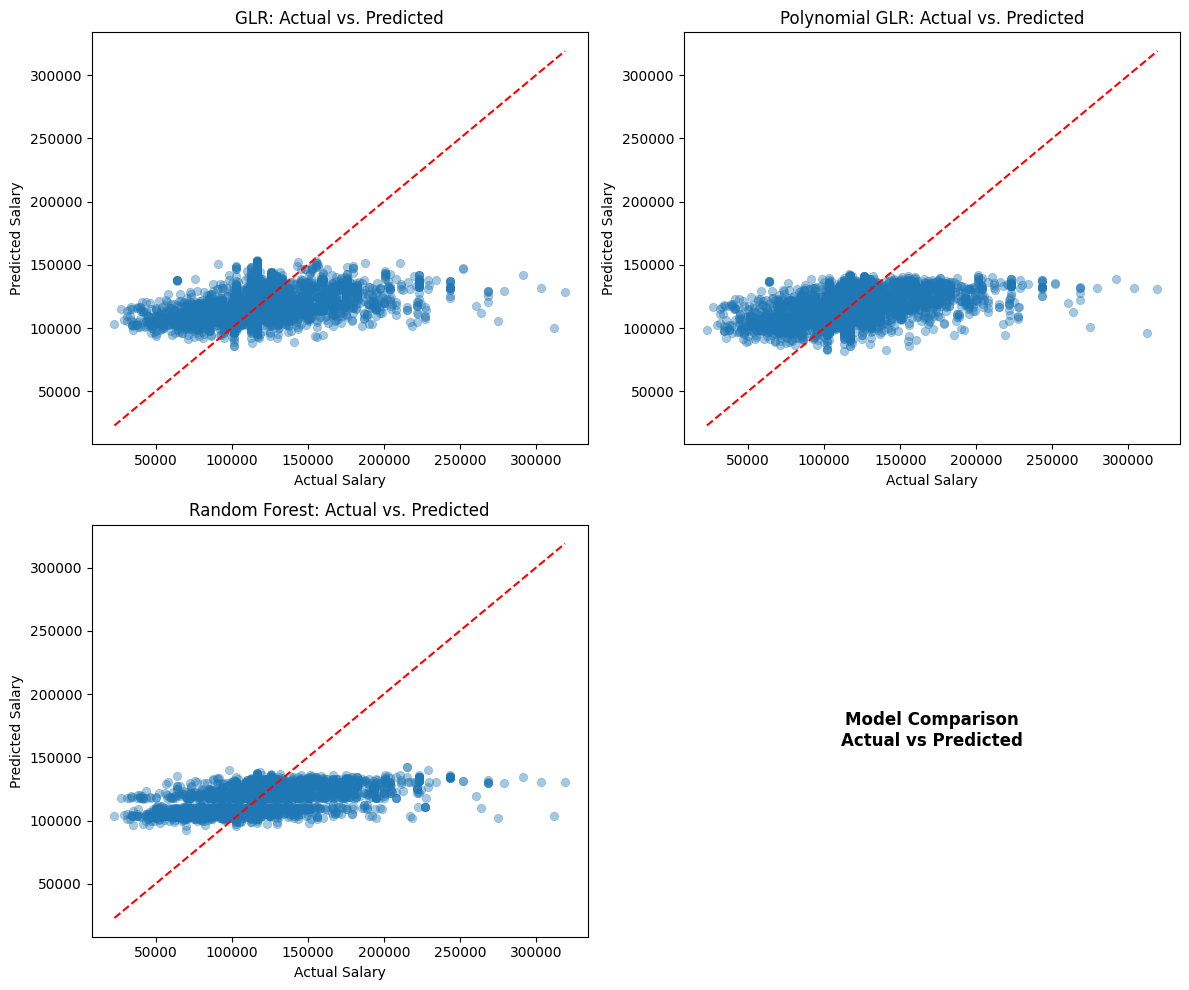

In [31]:
#| eval: true
#| echo: false
#| fig-align: center

import seaborn as sns
import matplotlib.pyplot as plt

pdf = predictions_combined.toPandas()

# Set up 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

models = [
    ("GLR", "pred_glr"),
    ("Polynomial GLR", "pred_poly"),
    ("Random Forest", "pred_rf")
]

for i, (name, col) in enumerate(models):
    sns.scatterplot(
        data=pdf,
        x="actual_salary",
        y=col,
        ax=axes[i],
        alpha=0.4,
        edgecolor=None
    )
    axes[i].set_title(f"{name}: Actual vs. Predicted")
    axes[i].set_xlabel("Actual Salary")
    axes[i].set_ylabel("Predicted Salary")
    axes[i].plot([pdf.actual_salary.min(), pdf.actual_salary.max()],
                 [pdf.actual_salary.min(), pdf.actual_salary.max()],
                 ls="--", color="red")

axes[3].axis("off")
axes[3].text(0.5, 0.5, "Model Comparison\nActual vs Predicted", 
             ha='center', va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig("output/actual_vs_predicted_grid.png")
plt.show()

## Evaluation Metrics
- Random Forest slightly outperforms both GLR models across all metrics, with the lowest RMSE and MAE, and the highest R² (15.5%). This suggests it captures more variance in salary predictions than the linear models.
- While Polynomial GLR improves marginally over the base GLR, the gain is small and may not justify the added complexity.
- AIC is only available for GLR models, and among them, the Polynomial GLR achieves a lower AIC (559,836.04), indicating a better model fit.
- BIC comparison favors the Random Forest model, indicating it balances accuracy and model complexity most effectively.

**Conclusion:**
Despite relatively low R² values across all models (indicating high unexplained variance, typical in salary prediction problems), the Random Forest model shows the best overall predictive performance and would be preferred for practical use.